# Bengali Fake News Detection with BiLSTM and DistilBERT (PyTorch)
Our project demonstrates fake news detection using BiLSTM and DistilBERT for Bengali text.

# Import Libraries

In [129]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.font_manager as fm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.calibration import calibration_curve
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from bnlp import BengaliCorpus as corpus
import re
from collections import Counter
import string
from imblearn.under_sampling import TomekLinks
from sklearn.feature_extraction.text import TfidfVectorizer
# import unicodedata

In [130]:
print(corpus.stopwords)
print(corpus.punctuations)
print(corpus.letters)
print(corpus.vowels)

['অতএব', 'অথচ', 'অথবা', 'অনুযায়ী', 'অনেক', 'অনেকে', 'অনেকেই', 'অন্তত', 'অন্য', 'অবধি', 'অবশ্য', 'অর্থাত', 'আই', 'আগামী', 'আগে', 'আগেই', 'আছে', 'আজ', 'আদ্যভাগে', 'আপনার', 'আপনি', 'আবার', 'আমরা', 'আমাকে', 'আমাদের', 'আমার', 'আমি', 'আর', 'আরও', 'ই', 'ইত্যাদি', 'ইহা', 'উচিত', 'উত্তর', 'উনি', 'উপর', 'উপরে', 'এ', 'এঁদের', 'এঁরা', 'এই', 'একই', 'একটি', 'একবার', 'একে', 'এক্', 'এখন', 'এখনও', 'এখানে', 'এখানেই', 'এটা', 'এটাই', 'এটি', 'এত', 'এতটাই', 'এতে', 'এদের', 'এব', 'এবং', 'এবার', 'এমন', 'এমনকী', 'এমনি', 'এর', 'এরা', 'এল', 'এস', 'এসে', 'ঐ', 'ও', 'ওঁদের', 'ওঁর', 'ওঁরা', 'ওই', 'ওকে', 'ওখানে', 'ওদের', 'ওর', 'ওরা', 'কখনও', 'কত', 'কবে', 'কমনে', 'কয়েক', 'কয়েকটি', 'করছে', 'করছেন', 'করতে', 'করবে', 'করবেন', 'করলে', 'করলেন', 'করা', 'করাই', 'করায়', 'করার', 'করি', 'করিতে', 'করিয়া', 'করিয়ে', 'করে', 'করেই', 'করেছিলেন', 'করেছে', 'করেছেন', 'করেন', 'কাউকে', 'কাছ', 'কাছে', 'কাজ', 'কাজে', 'কারও', 'কারণ', 'কি', 'কিংবা', 'কিছু', 'কিছুই', 'কিন্তু', 'কী', 'কে', 'কেউ', 'কেউই', 'কেখা', 'কেন', 'কোটি', 'কোন', 'কোনও'

# Load and Concatenate Bengali Datasets
using headline, category, content

In [ ]:
file1 = pd.read_csv('Fake-1K.csv')
file2 = pd.read_csv('LabeledAuthentic-7K.csv')
file3 = pd.read_csv('Authentic-48K.csv')
file4 = pd.read_csv('LabeledFake-1K.csv')
file5 = pd.read_csv('final_bn_data.csv')
file6 = pd.read_csv('BanMANI.csv', encoding='ISO-8859-1')
file7 = pd.read_csv("fake.csv")
file8 = pd.read_csv("Fact-watch.csv")
##############################################################           1=real, 0=fake
file1['label'] = 0  
file2['label'] = 1  
file3['label'] = 1  
file4['label'] = 0
file5['label'] = file5['label'].apply(lambda x: 1 if x == 1 else 0)
file6['label'] = file6['label'].apply(lambda x: 1 if x == 1 else 0) if 'label' in file6.columns else 0
file7['label'] = 0
file8['label'] = 0

df = pd.concat([file1, file3, file4, file5, file6, file7, file8], ignore_index=True)
df = shuffle(df, random_state=42).reset_index(drop=True)
df = df[df['label'].notna()].reset_index(drop=True)
print(f"Total samples: {len(df)} | Fake: {len(df[df['label'] == 0])} | Real: {len(df[df['label'] == 1])}")
print("Columns:", df.columns.tolist())
df = df[['headline', 'content', 'label']]
df.head()

Total samples: 67959 | Fake: 9281 | Real: 58678
Columns: ['articleID', 'domain', 'date', 'category', 'headline', 'content', 'label', 'source', 'relation', 'F-type', 'data_type', 'Label', 'altered_excerpt', 'original_excerpt', 'mani_news', 'original_news_article', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Review', 'title']


,headline,content,label
0,আইরিশ সীমান্ত নিয়ে ইইউ'র নতুন প্রস্তাব,ব্রেক্সিটের অন্যতম আলোচিত বিষয় আইরিশ সীমানা নি...,1
1,দ্বিতীয় দিনেও বেনাপোল বন্দরে আমদানি-রফতানি বন্ধ,অতিরিক্ত অর্থ আদায়সহ নানা অনিয়মের অভিযোগে ভারত...,1
2,"বিশৃঙ্খলায় ‘ইন্ধন’ আছে, প্রধানমন্ত্রীকে জানাব:...",শুক্রবার দুপুরে চট্টগ্রাম প্রেস ক্লাবে সংবাদ স...,1
3,"‘আন্দোলন নয়, সন্ত্রাস ও নাশকতার প্রস্তুতি নিচ্...",বিএনপি আগামী জাতীয় নির্বাচনকে সামনে রেখে আন্দো...,1
4,চট্টগ্রামে বিমানের ক্যাজুয়াল শ্রমিকদের অবরোধ ক...,চাকরি স্থায়ী করার দাবিতে চট্টগ্রামে অবরোধ কর্ম...,1


# Data Analysis
Bar Chart for Categories/Labels

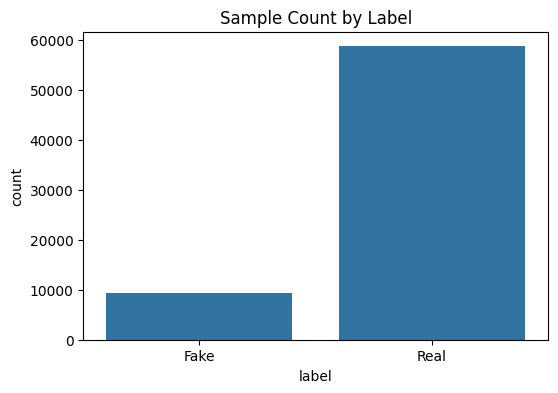

In [132]:
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.xticks([0,1], ['Fake', 'Real'])
plt.title('Sample Count by Label')
plt.show()

# Preprocessing
Clean Noise, Remove Stopwords, Punctuation, Digits, Letters, and Normalize

In [133]:

bangla_stopwords = set(corpus.stopwords)
def clean_text(text):
    text = str(text)
    text = re.sub(r'[a-zA-Z]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(rf'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'\s+', ' ', text)
    extra_punct = "‘’“”—…।"
    all_punct = string.punctuation + extra_punct
    text = re.sub(rf'[{re.escape(all_punct)}]', '', text)
    text = re.sub(r'\s+', ' ', text)
    words = text.split()
    words = [w for w in words if w not in bangla_stopwords]
    return ' '.join(words)

def combine_text(row):
    clean_headline = clean_text(row['headline'])
    clean_content = clean_text(row['content'])
    return f"{clean_headline} {clean_content}"

df['combined_text'] = df.apply(combine_text, axis=1)
df['clean_text'] = df['combined_text']

## Applying Tomek Links to Remove Overlapping Samples

In [134]:

vectorizer = TfidfVectorizer(max_features=1000)
X_vec = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label'].values

print("Before:",np.bincount(y.astype(int)))
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_vec, y)
print("After:", np.bincount(y_res.astype(int)))

mask = np.zeros(len(df), dtype=bool)
mask[tl.sample_indices_] = True
df = df.iloc[tl.sample_indices_].reset_index(drop=True)

Before: [ 9281 58678]
After: [ 9281 57810]
After: [ 9281 57810]


# Top 10 Most Used Words for Fake and Real (Bar Charts)

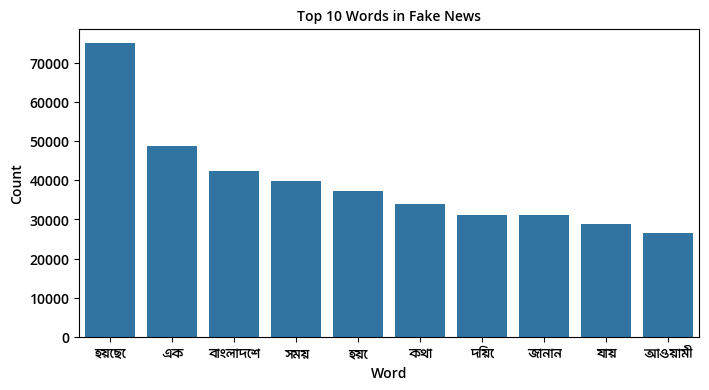

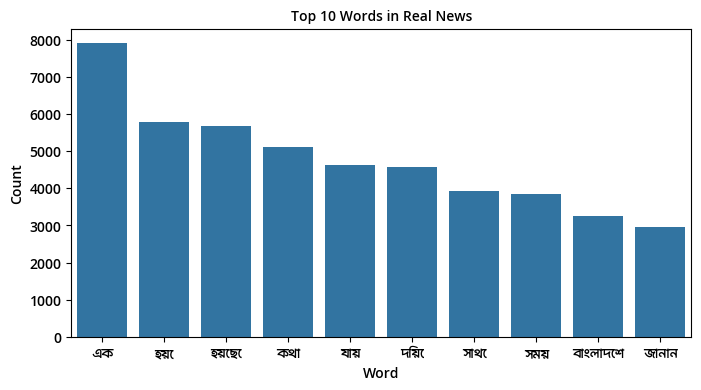

In [135]:

def plot_top_words(label, title):
    bengali_font_path = "Li Alinur Tatsama Unicode.ttf"
    bengali_font = fm.FontProperties(fname=bengali_font_path)
    
    texts = df[df['label']==label]['clean_text']
    all_words = ' '.join(texts).split()
    common = Counter(all_words).most_common(10)
    words, counts = zip(*common)
    plt.figure(figsize=(8,4))
    sns.barplot(x=list(words), y=list(counts))
    plt.title(title, fontproperties=bengali_font)
    plt.ylabel('Count', fontproperties=bengali_font)
    plt.xlabel('Word', fontproperties=bengali_font)
    plt.xticks(fontproperties=bengali_font)
    plt.yticks(fontproperties=bengali_font)
    plt.show()

plot_top_words(1, 'Top 10 Words in Fake News')
plot_top_words(0, 'Top 10 Words in Real News')

# WordClouds for Fake and Real News

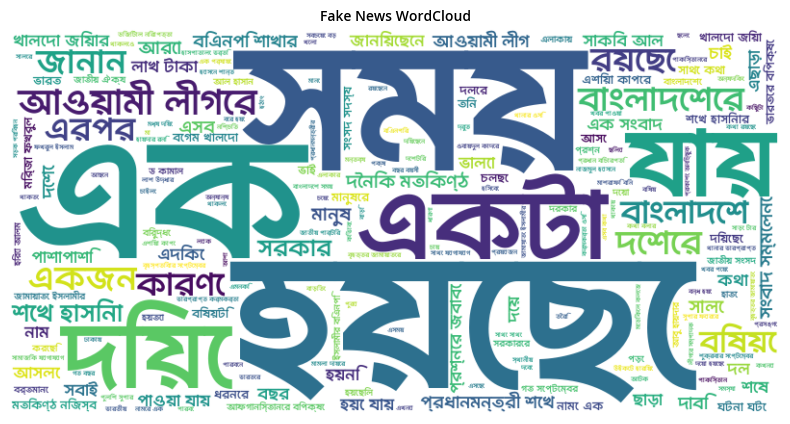

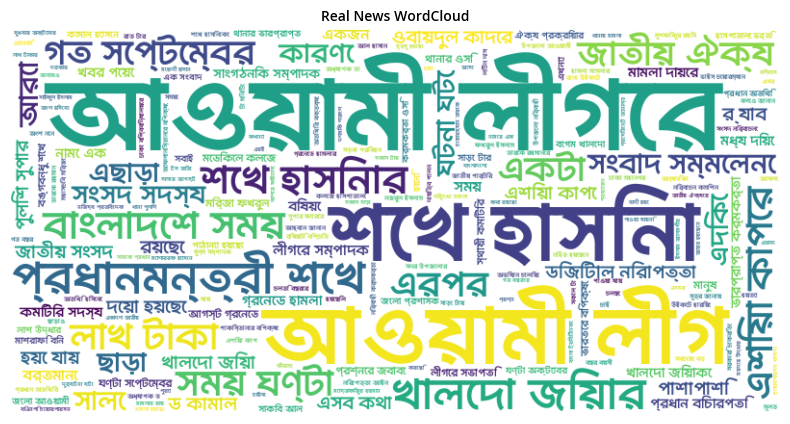

In [136]:

# Use regexp to match Bengali words, not single characters
bengali_word_regexp = r'[\u0980-\u09FF]+'

for label, title in zip([0,1], ['Fake News WordCloud', 'Real News WordCloud']):
    bengali_font_path = "Li Alinur Tatsama Unicode.ttf"
    text = ' '.join(df[df['label']==label]['clean_text'])
    wc = WordCloud(
        font_path=bengali_font_path,
        width=800,
        height=400,
        background_color='white',
        regexp=bengali_word_regexp
    ).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontproperties=fm.FontProperties(fname=bengali_font_path))
    plt.show()

# Feature Extraction:
DistilBERT Tokenization & Embedding

In [137]:

MODEL = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL)
bert_model = DistilBertModel.from_pretrained(MODEL)

MAX_LEN = 128

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        encoding = tokenizer(
            self.texts[idx],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
    
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Get tokenized and embedded output from DistilBERT

In [138]:

sample_text = "এটি একটি বাংলা বাক্য।"
encoding = tokenizer(
    sample_text,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
print("Tokenized input_ids:", encoding['input_ids'])
print("Attention mask:", encoding['attention_mask'])

with torch.no_grad():
    bert_output = bert_model(
        input_ids=encoding['input_ids'],
        attention_mask=encoding['attention_mask']
    )
print("DistilBERT last_hidden_state shape:", bert_output.last_hidden_state.shape)
print("DistilBERT last_hidden_state:", bert_output.last_hidden_state)

Tokenized input_ids: tensor([[  101, 25757, 14374, 49133, 17660, 13104, 15215,   920,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,  

In [139]:

texts = df['clean_text'].iloc[:2].tolist()
encoding = tokenizer(
    texts,
    add_special_tokens=True,
    max_length=MAX_LEN,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
print("Tokenized input_ids shape:", encoding['input_ids'].shape)
print("Tokenized input_ids:", encoding['input_ids'])
print("Attention mask:", encoding['attention_mask'])

Tokenized input_ids shape: torch.Size([2, 128])
Tokenized input_ids: tensor([[   101,    938,  14998,  82742,  22875,    978,  13100,  29454,  45947,
            939,  14998,  89362,  11128,    968,  21790,  83924,  78639,    970,
          80187,  13104,  27556,  12235,  88684,  11128,  58918,  76837,  16431,
          43868,    970,  12235,  34070,  13228,    938,  14998,  82742,  22875,
            978,  13100,  29454,  12079,    968,  21790,  83924,  78639,    968,
          29261, 107843,  47356,  49178,  58914,  11128,    968,  21790,  83924,
          98191,    939,  89362,  11128,  16431,  82445,  96032,  15477,    973,
          69778,  28410,  24383,  50263,    939,  14998,  89362,  11128,    967,
          11199,  13542, 111237,  19910, 111237, 104306,  11421,    978,  15002,
          11128,  38833,  11737,    938, 106352,  24758,  38628,  15002,  70115,
          50644,    958,  11421,  80198,  12079,  39893,  11128,  59136,  40685,
          26145,  13542,    968,  21790,

# Train/Validation Split 
(using clean_text from combined fields)

Set device for model and tensors

In [140]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [141]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

train_dataset = NewsDataset(train_texts.tolist(), train_labels.tolist())
val_dataset = NewsDataset(val_texts.tolist(), val_labels.tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

for batch in train_loader:
    print(batch['input_ids'])
    break
for batch in val_loader:
    print(batch['input_ids'])
    break

tensor([[   101,  33151,  11128,  ...,  26145,  12235,    102],
        [   101,    972,  26145,  ...,    967, 111236,    102],
        [   101,    975,  19668,  ...,  20979,    974,    102],
        ...,
        [   101,  18601,  15258,  ...,  15691,  74501,    102],
        [   101,    953,  28725,  ...,    968,  12079,    102],
        [   101, 101366,    968,  ...,  57189,    956,    102]])
tensor([[   101,    958,  21790,  ..., 101655,  11199,    102],
        [   101,    968,  80187,  ...,  16166,  42651,    102],
        [   101,    967,  18262,  ...,  18243,    938,    102],
        ...,
        [   101,    953,  47356,  ..., 111239,  72593,    102],
        [   101,    102,      0,  ...,      0,      0,      0],
        [   101,    979,  30831,  ...,  96397,  11421,    102]])
tensor([[   101,    958,  21790,  ..., 101655,  11199,    102],
        [   101,    968,  80187,  ...,  16166,  42651,    102],
        [   101,    967,  18262,  ...,  18243,    938,    102],
        ...,

# Enhanced BiLSTM Model 
with LayerNorm, Attention, Residual, and Pooling

In [142]:

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)

    def forward(self, lstm_out, mask=None):
        # lstm_out: (batch, seq_len, hidden_dim)
        attn_weights = self.attn(lstm_out).squeeze(-1)  # (batch, seq_len)
        if mask is not None:
            attn_weights = attn_weights.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = torch.sum(lstm_out * attn_weights.unsqueeze(-1), dim=1)
        return attended

class BiLSTMClassifier(nn.Module):
    def __init__(self, bert_model, lstm_units=128, num_layers=2, dense_units=256, dropout_rate=0.5):
        super().__init__()
        self.bert = bert_model
        self.layernorm_in = nn.LayerNorm(768)
        self.lstm = nn.LSTM(
            input_size=768,
            hidden_size=lstm_units,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.layernorm_out = nn.LayerNorm(lstm_units*2)
        self.attention = Attention(lstm_units*2)
        self.dropout = nn.Dropout(dropout_rate)
        # Pooling output is lstm_units*2 (attn) + lstm_units*2 (avg) + lstm_units*2 (max) + 768 (residual)
        self.fc1 = nn.Linear(lstm_units*2*3 + 768, dense_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(dense_units, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state  # (batch, seq_len, 768)
        x = self.layernorm_in(bert_out)
        lstm_out, _ = self.lstm(x)  # (batch, seq_len, lstm_units*2)
        lstm_out = self.layernorm_out(lstm_out)
        # Attention
        attn_feat = self.attention(lstm_out, mask=attention_mask)
        # Pooling
        avg_pool = torch.mean(lstm_out, dim=1)
        max_pool, _ = torch.max(lstm_out, dim=1)
        # Residual connection: use [CLS] token from BERT (first token)
        residual = bert_out[:, 0, :]  # (batch, 768)
        # Concatenate all features
        final_feat = torch.cat([attn_feat, avg_pool, max_pool, residual], dim=1)
        out = self.dropout(final_feat)  # Dropout applied here
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return self.sigmoid(out)

In [143]:
# class BiLSTMClassifier(nn.Module):
#     def __init__(self, bert_model, lstm_units=128, dense_units=256, dropout_rate=0.5):
#         super().__init__()
#         self.bert = bert_model
#         self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_units, num_layers=1, batch_first=True, bidirectional=True)
#                 self.dropout = nn.Dropout(dropout_rate)
#         self.fc1 = nn.Linear(lstm_units*2, dense_units)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(dense_units, 1)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, input_ids, attention_mask):
#         with torch.no_grad():
#             bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
#         lstm_out, _ = self.lstm(bert_out)
#         out = lstm_out[:,0,:]
#                 out = self.dropout(out)
#         out = self.fc1(out)
#         out = self.relu(out)
#         out = self.fc2(out)
#         return self.sigmoid(out)

# Hyperparameter optimization via grid search

In [144]:
from itertools import product

def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0
    for batch in loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * input_ids.size(0)
        preds = (outputs > 0.5).float()
        total_correct += (preds == labels).sum().item()
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset)

def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * input_ids.size(0)
            preds = (outputs > 0.5).float()
            total_correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(outputs.cpu().numpy())
    return total_loss / len(loader.dataset), total_correct / len(loader.dataset), np.array(all_labels), np.array(all_preds)

# param_grid = {
#     'optimizer': ['adam', 'rmsprop'],
#     'lstm_units': [64, 128],
#     'dense_units': [32, 256],
#     'dropout_rate': [0.3, 0.5],
#     'batch_size': [16, 32]
# }

def get_optimizer(opt_name, params, lr=2e-5):
    if opt_name == 'adam':
        return optim.Adam(params, lr=lr)
    elif opt_name == 'rmsprop':
        return optim.RMSprop(params, lr=lr)
    else:
        raise ValueError('Unknown optimizer')

# # Generate all combinations
# keys, values = zip(*param_grid.items())
# best_acc = 0
# best_params = None

# for combo in product(*values):
#     params = dict(zip(keys, combo))
#     print(f"Testing params: {params}")

#     # Create new model and optimizer for each run
#     model = BiLSTMClassifier(
#         bert_model,
#         lstm_units=params['lstm_units'],
#         dense_units=params['dense_units'],
#         dropout_rate=params['dropout_rate']
#     ).to(device)
#     optimizer = get_optimizer(params['optimizer'], model.parameters())
#     criterion = nn.BCELoss()

#     # Use batch_size from params
#     train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=params['batch_size'])

#     # Train for 1 epoch (or more for better results)
#     train_epoch(model, train_loader, optimizer, criterion)
#     val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
#     print(f"Val Acc: {val_acc:.4f}")

#     if val_acc > best_acc:
#         best_acc = val_acc
#         best_params = params

# print(f"Best Params: {best_params} | Best Val Acc: {best_acc:.4f}")

Set hyperparameters after grid search

In [145]:


optimizer_name = 'adam'
lstm_units = 64
dense_units = 256
dropout_rate = 0.3
batch_size = 16

model = BiLSTMClassifier(bert_model, lstm_units=lstm_units, dense_units=dense_units, dropout_rate=dropout_rate).to(device)
optimizer = get_optimizer(optimizer_name, model.parameters())
criterion = nn.BCELoss()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

for batch in train_loader:
    print(batch['input_ids'])
    break
for batch in val_loader:
    print(batch['input_ids'])
    break

tensor([[   101,    968,  80187,  ...,    939,  88684,    102],
        [   101,    937,  45733,  ...,  11421,    978,    102],
        [   101,    970,  65240,  ...,  19668,  13458,    102],
        ...,
        [   101,  27470,  11199,  ...,    978,  22756,    102],
        [   101,    958, 100764,  ...,  40652,    967,    102],
        [   101,  41431, 111240,  ...,  13458,  33151,    102]])
tensor([[   101,    958,  21790,  ..., 101655,  11199,    102],
        [   101,    968,  80187,  ...,  16166,  42651,    102],
        [   101,    967,  18262,  ...,  18243,    938,    102],
        ...,
        [   101,    953,  47356,  ..., 111239,  72593,    102],
        [   101,    102,      0,  ...,      0,      0,      0],
        [   101,    979,  30831,  ...,  96397,  11421,    102]])


# Training Loop
(6 epochs, showing val accuracy/loss)
Using the hyperparameters from hyperparameter tuning

In [147]:
train_losses, val_losses, val_accuracies = [], [], []
for epoch in range(6):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc, _, _ = eval_epoch(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1}/6 | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/15 | Train Loss: 0.2425 | Train Acc: 0.9206 | Val Loss: 0.2464 | Val Acc: 0.9203
Epoch 2/15 | Train Loss: 0.2367 | Train Acc: 0.9233 | Val Loss: 0.2432 | Val Acc: 0.9247
Epoch 3/15 | Train Loss: 0.2304 | Train Acc: 0.9248 | Val Loss: 0.2426 | Val Acc: 0.9218
Epoch 4/15 | Train Loss: 0.2268 | Train Acc: 0.9266 | Val Loss: 0.2346 | Val Acc: 0.9261
Epoch 5/15 | Train Loss: 0.2217 | Train Acc: 0.9286 | Val Loss: 0.2325 | Val Acc: 0.9279
Epoch 6/15 | Train Loss: 0.2171 | Train Acc: 0.9301 | Val Loss: 0.2362 | Val Acc: 0.9253


# Evaluation
Accuracy, F1, Precision, Recall, Confusion Matrix, ROC Curve

Validation Accuracy: 0.9253
F1 Score: 0.9584
Precision: 0.9223
Recall: 0.9973


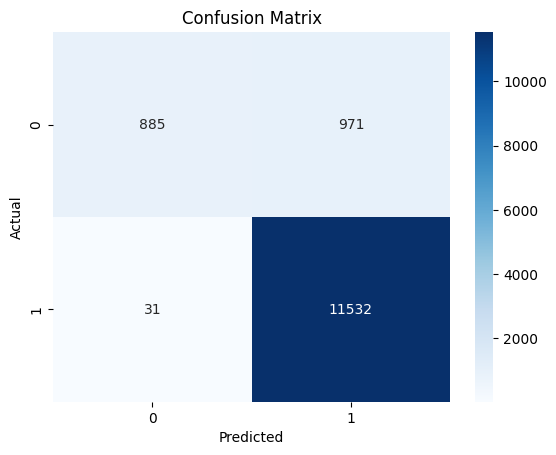

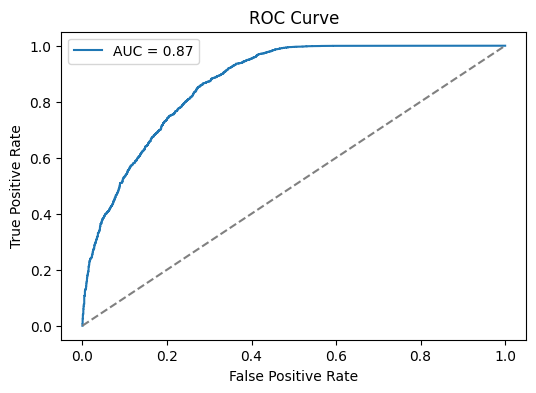

In [179]:

val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader, criterion)
y_pred_label = (y_pred > 0.5).astype(int)

print(f"Validation Accuracy: {accuracy_score(y_true, y_pred_label):.4f}")
print(f"F1 Score: {f1_score(y_true, y_pred_label):.4f}")
print(f"Precision: {precision_score(y_true, y_pred_label):.4f}")
print(f"Recall: {recall_score(y_true, y_pred_label):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_label)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

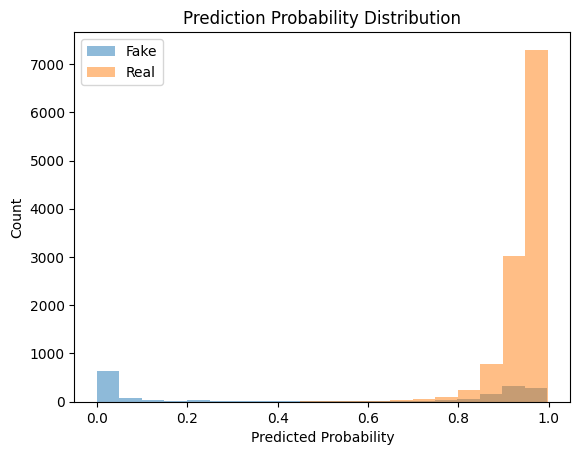

In [180]:
plt.hist(y_pred[y_true==0], bins=20, alpha=0.5, label='Fake')
plt.hist(y_pred[y_true==1], bins=20, alpha=0.5, label='Real')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Probability Distribution')
plt.show()

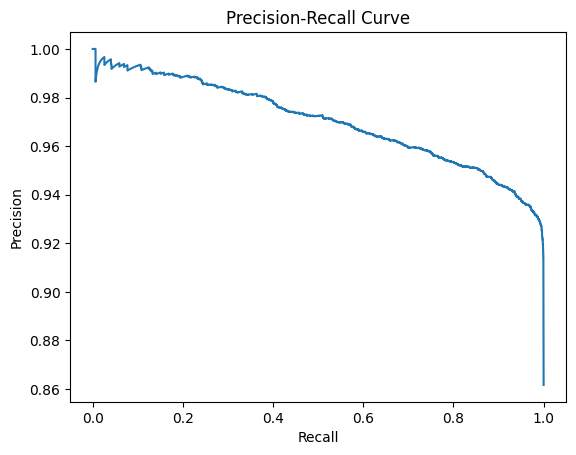

In [181]:
precision, recall, _ = precision_recall_curve(y_true, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

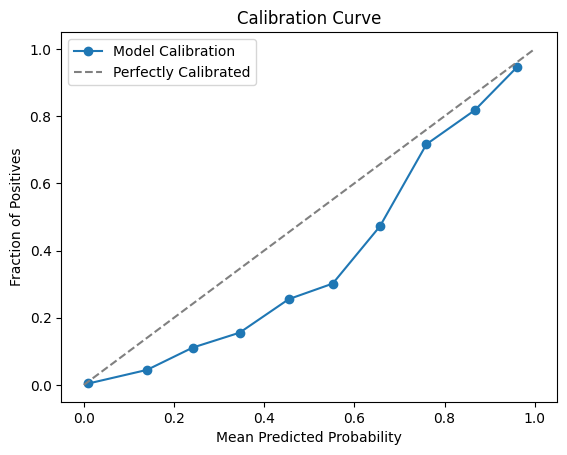

In [182]:
prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o', label='Model Calibration')
plt.plot([0,1],[0,1],'--', color='gray', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [183]:
torch.save(model.state_dict(), 'bilstm_distilbert_bn.pth')

# Check news here

In [177]:
custom_headline = "চাঁদের মাটিতে সবজি চাষে আংশিক সাফল্য পেল বিজ্ঞানীরা"
custom_content = "নাসার গবেষকরা চাঁদের মাটি থেকে আনা নমুনায় কিছু সবজির বীজ অঙ্কুরোদগম করতে সক্ষম হয়েছেন, তবে পূর্ণ বিকাশে বাধা এসেছে মাটির খনিজ কাঠামোর কারণে। এটি ভবিষ্যতে চাঁদে কৃষিকাজের সম্ভাবনা তৈরি করলেও, এখনো তা অনিশ্চিত।"

In [198]:
custom_headline = "জলপাই তেলে মাথা মালিশ করলে বন্ধ্যাত্ব নিরাময় হয় — দাবি ফেসবুক পোস্টে"
custom_content = "সাম্প্রতিক এক ফেসবুক পোস্টে বলা হয়েছে, জলপাই তেল দিয়ে নিয়মিত মাথায় মালিশ করলে নাকি বন্ধ্যাত্বের সমস্যা দূর হয়। তবে এই দাবি কোনো বৈজ্ঞানিক গবেষণায় প্রমাণিত নয়। চিকিৎসকেরা বলছেন, এই ধরনের ভ্রান্ত তথ্য স্বাস্থ্যঝুঁকি বাড়াতে পারে।"

In [199]:
custom_text = f"{custom_headline} {custom_content}"
custom_clean = clean_text(custom_text)
encoding = tokenizer(
    custom_clean,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)
input_ids = encoding['input_ids'].to(device)
attention_mask = encoding['attention_mask'].to(device)

In [200]:
model.eval()
with torch.no_grad():
    start_time = time.time()
    output = model(input_ids, attention_mask)
    end_time = time.time()
    pred = (output.item() > 0.5)
    label = "Fake" if pred else "Real"
    print(f"Prediction: {label}")
    print(f"Interference time: {(end_time - start_time)*1000:.2f} ms")

Prediction: Fake
Interference time: 7.51 ms
